<div align="center">
  <h1></h1>
  <h1>Task 2: Fine-tune LLM for Code Generation</h1>
  <h3 align="center">!!!!! Name : Prateek Kumar Sharma, Matriculation Number: 428451 !!!!!</h4>
</div>


**The primary objective of this project is to show the ability to fine-tune to enhance the model performance in a specific task. Also, it will show how existing large language models can be used in the data collection process to enhance relatively small models. This will involve the use of a suitable dataset for fine-tuning a model for code generation, the choice of a suitable small model to be fine-tuned on the Colab notebook, the design of the experiment setup and evaluation matrices and choosing the correct prompt for generation of the synthesised data.**

## Install Libraries

In [ ]:
# Install necessary libraries

# Install transformers version 4.38.2
!pip install -q transformers==4.38.2

# Install auto-gptq with cu118 support from the extra index URL
!pip install -q auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/

# Install optimum library
!pip install -q optimum

# Upgrade peft library
!pip install -q -U peft

# Install trl version 0.7.1
!pip install -q trl==0.7.1

# Upgrade bitsandbytes library from PyPI
!pip install -i https://pypi.org/simple/ bitsandbytes --upgrade

# Install accelerate library from GitHub repository
!pip install git+https://github.com/huggingface/accelerate

# Install rouge-score library
!pip install rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.0/417.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

## Load the dataset benchmark and split it in the designed ratio.

We will be using the APPS dataset to fine-tune an optimized version of our Model. APPS is a benchmark for code generation with 10000 problems. It can be used to evaluate the ability of language models to generate code from natural language specifications. We Will be Taking Random 500 Problems, and Split in into this Ratio : Test - 300 , Train - 100, Validation - 100.

In [ ]:
# Import the load_dataset function from the datasets module
from datasets import load_dataset

# Use the load_dataset function to load the "codeparrot/apps" dataset
# This dataset contains code snippets from various applications
dataset = load_dataset("codeparrot/apps")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for codeparrot/apps contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/codeparrot/apps
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
# Print the dataset to display information about it
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['problem_id', 'question', 'solutions', 'input_output', 'difficulty', 'url', 'starter_code'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['problem_id', 'question', 'solutions', 'input_output', 'difficulty', 'url', 'starter_code'],
        num_rows: 5000
    })
})


In [ ]:
# Shuffle the "train" split of the dataset using a seed value of 42
# This ensures that the data is shuffled consistently for reproducibility
shuffled_dataset = dataset["train"].shuffle(seed=42)

# Select the first 500 samples from the shuffled dataset
# This creates a subset of the dataset containing 500 samples
# The select function is used with a list comprehension to specify the indices of the samples to select
# In this case, we select samples with indices ranging from 0 to 499
selected_dataset = shuffled_dataset.select([i for i in range(500)])

# Assign the selected subset of the dataset to the Masterdataset variable
Masterdataset = selected_dataset

In [ ]:
print(len(Masterdataset))

500


Determining the split ratio between training, testing datasets and validation datasets is crucial for model evaluation. The dataset split ratio determines how the available data is divided into training and testing sets for model evaluation.

After deliberation, we settled on a [60/20/20] split ratio to ensure an adequate balance between training, testing and validation data.

In [ ]:
from datasets import Dataset

# Split the Masterdataset into train, test, and validation sets based on the designed ratio

# Select the first 300 samples from the Masterdataset for the training set
train_data = Dataset.from_dict(Masterdataset[:300])

# Select samples from index 300 to 399 (exclusive) from the Masterdataset for the test set
test_data = Dataset.from_dict(Masterdataset[300:400])

# Select samples from index 400 to 499 (exclusive) from the Masterdataset for the validation set
validation_data = Dataset.from_dict(Masterdataset[400:500])

## Loaded The pre-trained model [Model A]

### Basic Imports

In [ ]:
import torch                                # Deep Learning Framework
import time                                 # Measure inference time
import pandas as pd                         # For table dataset structure
import numpy as np                          # Numerical operations on the CPU
from datasets import load_dataset           # Loading the dataseet
import random                               # Will use for shuffling

### Loading The Pre-Trained-Model

We will be using the microsoft/phi-1_5. The language model Phi-1.5 is a Transformer with 1.3 billion parameters. It was trained using the same data sources as phi-1, augmented with a new data source that consists of various NLP synthetic texts. When assessed against benchmarks testing common sense, language understanding, and logical reasoning, Phi-1.5 demonstrates a nearly state-of-the-art performance among models with less than 10 billion parameters.

In [ ]:
# Import necessary modules and classes from the transformers library
from transformers import AutoModelForCausalLM, AutoTokenizer

# Define the model name to be used
model_name = "microsoft/phi-1_5"

# Load the pre-trained model for causal language modeling using the specified model name
# The AutoModelForCausalLM class automatically selects the appropriate model architecture for the specified task
modelA = AutoModelForCausalLM.from_pretrained(model_name)


Quantization of a pre-trained model refers to the process of reducing the precision of its parameters. This reduction typically involves converting floating-point numbers (which require more memory and computation) to fixed-point numbers (which are simpler and require less memory). There are several reasons why we might want to perform quantization on a pre-trained model:

1.   Memory Efficiency
2.   Speedup Inference
3.   Compatibility

So, For That Reason We Have To Must Do Quantization of our Model



### Loading the Quantized Model

In [ ]:
# Import the BitsAndBytesConfig class from the transformers library
from transformers import BitsAndBytesConfig

# 1. Define the quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # Load model weights in 4-bit format for memory efficiency
    bnb_4bit_use_double_quant=True,        # Use double quantization to quantize quantization constants, saving additional space
    bnb_4bit_quant_type="nf4",             # Use 4-bit NormalFloat Quantization, ideal for normal weights, ensuring weights are within [-1, 1]
    bnb_4bit_compute_dtype=torch.float16  # Convert quantized weights to 16-bit floating-point format before computations
)

# 2. Load the model with the specified quantization configuration
modelA = AutoModelForCausalLM.from_pretrained(
    model_name,                            # Name or path of the pre-trained model
    quantization_config=bnb_config,        # Pass the quantization configuration to the model
    device_map="auto"                      # Automatically assign the model to available devices
)

### Loading the Tokenizer

This Model did not use padding during training (normal thing for language models since we can just divide any piece of text into perfect blocks and treat each line as a sequence).

Because the models ignore eos outputs by definition (there is nothing to predict), it is *customary to set the padding token as eos *(since it should also be ignored).

The padding side was also set incorrectly to left by default in the library. So we will have to correct that as well.

In [ ]:
# Import the AutoTokenizer class from the transformers library
from transformers import AutoTokenizer

# Load the tokenizer associated with the pre-trained model using the specified model name
# The AutoTokenizer class automatically selects the appropriate tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [ ]:
# Set the padding token of the tokenizer to be the same as the end-of-sequence (EOS) token
tokenizer.pad_token = tokenizer.eos_token

# Set the padding side of the tokenizer to be "right"
# This means that padding tokens will be added to the right side of the sequences
tokenizer.padding_side = "right"


### Just To Test The Model, Whether it is Working Properly or Not?

In [ ]:
# Define the input text to be translated
input_text = "translate English to German: How old are you?"

# Tokenize the input text using the tokenizer
# Convert the tokenized input to PyTorch tensors and move them to the GPU (if available)
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

# Generate the translated text using the pre-trained model
outputs = modelA.generate(input_ids)

# Decode the generated output tokens into human-readable text using the tokenizer
decoded_output = tokenizer.decode(outputs[0])

# Print the decoded output
print(decoded_output)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


translate English to German: How old are you?

Answer: "I am 15 years


## Test model A on the testing dataset using the selected evaluation metric.

The ROUGE library helps measure how good generated text is by comparing it to a reference summary. It uses different metrics like precision, recall, and F1-score to see how much the generated text overlaps with the reference. ROUGE comes in different versions, like ROUGE-N (1 and 2), ROUGE-L each looking at different aspects of text quality. It's a handy tool for researchers to check and improve their text generation models.

In [ ]:
# Import the rouge_scorer function from the rouge_score module
from rouge_score import rouge_scorer

# The rouge_scorer function provides an interface for computing ROUGE scores for text summarization tasks
# It allows you to compute various ROUGE metrics, such as ROUGE-N, ROUGE-L, and ROUGE-W
# ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics used to evaluate the quality of summaries or translations
# It measures the overlap between the generated text and the reference text in terms of n-grams, word sequences, or longest common subsequences

In [ ]:
# Convert the test_data to a DataFrame using pandas
# This creates a DataFrame object with the test_data as its contents
test_dataDF = pd.DataFrame(test_data)

In [ ]:
# Function to calculate the mean precision and recall scores of the model in terms of Rouge1, Rouge2, and RougeL
def score_calc(dataframe):
    # Initialize a RougeScorer object with specified metrics (Rouge1, Rouge2, RougeL) and use_stemmer=True
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Calculate Rouge scores for each sample in the dataframe and store them in the 'scores' Series
    scores = dataframe.apply(lambda x:scorer.score(x.predictions, x.solutions), axis=1)

    # Assign Rouge precision and recall scores for each metric to new columns in the dataframe
    dataframe = dataframe.assign(rouge1_precision = scores.map(lambda x: x['rouge1'].precision),
                                 rouge1_recall= scores.map(lambda x: x['rouge1'].recall))
    dataframe = dataframe.assign(rouge2_precision = scores.map(lambda x: x['rouge2'].precision),
                                 rouge2_recall= scores.map(lambda x: x['rouge2'].recall))
    dataframe = dataframe.assign(rougeL_precision = scores.map(lambda x: x['rougeL'].precision),
                                 rougeL_recall= scores.map(lambda x: x['rougeL'].recall))

    return dataframe

# Function to create an evaluation dataframe containing mean precision and recall scores for Rouge1, Rouge2, and RougeL
def evaluation_dataframe(data):
    metrics = ['rouge1', 'rouge2', 'rougeL']
    df = pd.DataFrame(columns = ['Precision', 'Recall'], index = metrics)

    # Calculate mean precision and recall scores for each metric and store them in the evaluation dataframe
    for metric_name in metrics:
        df.loc[metric_name] = [np.round(data[metric_name+'_precision'].mean()*100,2),
                               np.round(data[metric_name+'_recall'].mean()*100, 2)]

    return df

# Main evaluation function
def evaluate_main(test_dataframe, model)->None:
    # Sample 100 records from the test dataframe for evaluation
    data = test_dataframe.sample(n = 100,
                                 replace = False,
                                 random_state = 69,
                                 ignore_index = True)

    # Generate predictions for the sampled records using the provided model
    temp = data['question'].map(lambda x : model.generate(tokenizer(x, return_tensors="pt").input_ids.to("cuda"), max_new_tokens=600)[0])
    data = data.assign(predictions=temp.map(lambda x:tokenizer.decode(x, skip_special_tokens=True)))

    # Calculate Rouge scores and add them to the dataframe
    data = score_calc(data)

    # Generate and display the evaluation dataframe containing mean precision and recall scores for Rouge1, Rouge2, and RougeL
    display(evaluation_dataframe(data))

    return data


In [ ]:
# Call the evaluate_main function with the test_dataDF DataFrame and modelA model as arguments,
# and assign the result to the variable 'result'
result = evaluate_main(test_dataDF, modelA)

Token indices sequence length is longer than the specified maximum sequence length for this model (2110 > 2048). Running this sequence through the model will result in indexing errors
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


,Precision,Recall
rouge1,17.99,28.09
rouge2,4.09,7.14
rougeL,11.78,18.72


These metrics show how well a pre-trained model's generated text matches a reference solution:

ROUGE-1: Around 18% of the words in the generated text match those in the reference solution, and 28% of the reference solution words are in the generated text.

ROUGE-2: Only about 4% of word pairs in the generated text match those in the reference solution, and 7% of the reference solution's word pairs are in the generated text.

ROUGE-L: Approximately 12% of the longest common subsequence of words in the generated text matches that of the reference solution, and 19% of the reference solution's longest common subsequence is in the generated text.

## Fine-tune model A on the training dataset ---> [Model B]

In [ ]:
# Define a function to format instruction for generating code
def format_instruction(question, solutions):
    """
    Format instruction for generating code.

    Args:
        question (str): The problem statement/question.
        solutions (str): The generated code solutions.

    Returns:
        str: Formatted instruction including the problem statement and generated code.
    """
    # Format the instruction with problem statement/question and generated code
    formatted_instruction = f"""### Instruction:
      Write a Code in Python For the Given Problem Statement.

      ### Prompt:
        {question.strip()}  # Remove leading and trailing whitespace from the question

      ### Code Generated:
        {solutions}  # Include the generated code solutions

        """.strip()  # Strip leading and trailing whitespace from the formatted instruction

    return formatted_instruction  # Return the formatted instruction


Before training, we need to put each Row of Dataset in prompt format. Given a question q and Solution S, we will use the following format:

### Instruction:
Write a Python Code For Given Problem Statement

### Input:
{Q}

### Code Generated:
{S}

In [ ]:
# Define a function to convert train_data to instruction format
def convert_to_instruction_format(train_data):
    """
    Convert train_data to instruction format.

    Args:
        train_data (DataFrame): DataFrame containing training data with columns "question" and "solutions".

    Returns:
        dict: Dictionary containing formatted instruction with key "Code".
    """
    # Format instruction for each sample in train_data and store in a dictionary
    formatted_instruction = {"Code": format_instruction(train_data["question"], train_data["solutions"])}

    return formatted_instruction  # Return the dictionary containing formatted instruction


In [ ]:
# Define a function to process dataset by converting it to instruction format and removing unnecessary columns
def process_dataset(data):
    """
    Process dataset by converting it to instruction format and removing unnecessary columns.

    Args:
        data (Dataset): Dataset containing input data with columns "problem_id", "question", "solutions",
                        "input_output", "difficulty", "url", and "starter_code".

    Returns:
        Dataset: Processed dataset with columns removed and instruction format applied.
    """
    # Map the convert_to_instruction_format function to each sample in the dataset
    # This converts each sample to instruction format and stores the result in a new column "Code"
    # The remove_columns method is then used to remove unnecessary columns from the dataset
    processed_data = data.map(convert_to_instruction_format).remove_columns(['problem_id', 'question', 'solutions',
                                                                              'input_output', 'difficulty',
                                                                              'url', 'starter_code'])

    return processed_data  # Return the processed dataset


In [ ]:
# Process the training data by converting it to instruction format and removing unnecessary columns
# Select the first 300 samples from the training data and apply processing
FTtrain_data = process_dataset(train_data.select([i for i in range(300)]))

# Process the test data by converting it to instruction format and removing unnecessary columns
# Select the first 100 samples from the test data and apply processing
FTtest_data = process_dataset(test_data.select([i for i in range(100)]))

# Process the validation data by converting it to instruction format and removing unnecessary columns
# Select the first 100 samples from the validation data and apply processing
FTvalidation_data = process_dataset(validation_data.select([i for i in range(100)]))

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

### PEFT SETUP

Then we have to apply some preprocessing to the model to prepare it for training. For that use the prepare_model_for_kbit_training method from PEFT.

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# 1. prepare model for LoRA
model = prepare_model_for_kbit_training(modelA)      # involves float conversions that help stabilize training

# 2. Setup LoRA Config
lora_config = LoraConfig(
    r=16,                                                       # The rank of the LoRA matrices A, B
    lora_alpha=64,                                              # Scales the product AB
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],    # Will apply LoRA to attention matrices
    lora_dropout=0.1,                                           # Dropout to help lessen overfitting
    bias="none",                                                # Don't train the bias parameter
    task_type="CAUSAL_LM"
)

# 3. Get model with unfrozen LoRA layers
model = get_peft_model(modelA, lora_config)

### Training

Let's set up the training hyperparameters in TrainingArguments.

In [ ]:
# Import the TrainingArguments class from the transformers library
from transformers import TrainingArguments

# Define the training arguments for the model
training_arguments = TrainingArguments(
    fp16=True,                           # Use 16-bit floating-point precision for training computations
    # Batch-related parameters
    per_device_train_batch_size=2,       # Batch size per GPU device
    gradient_accumulation_steps=4,       # Number of batches to accumulate gradients before performing optimization step
    # Optimizer-related parameters
    optim="paged_adamw_32bit",           # Optimizer variant designed for efficient use on 32-bit GPUs
    learning_rate=1e-4,                  # Learning rate for the optimizer
    warmup_ratio=0.05,                   # Ratio of warmup steps during learning rate warmup
    lr_scheduler_type="cosine",          # Type of learning rate scheduler to use (cosine decay)
    max_grad_norm=0.3,                   # Maximum gradient norm to prevent gradient explosion
    # Epochs and saving-related parameters
    num_train_epochs=2,                  # Number of training epochs
    save_strategy="epoch",               # Strategy for saving model checkpoints (after each epoch)
    output_dir="epoch-finetuned",        # Directory to save the model checkpoints
    # Validation-related parameters
    evaluation_strategy="steps",         # Strategy for evaluation during training (evaluate after a certain number of steps)
    eval_steps=0.2,                      # Number of steps to evaluate after (20% of training steps)
    # Logging-related parameters
    logging_steps=1,                     # Number of steps between two logs
    group_by_length=True,                # Group sentences of similar length to minimize padding
    seed=42,                             # Seed for reproducibility
)

# Enable gradient checkpointing to store less activations and recompute later
modelA.gradient_checkpointing_enable()

# Disable using attention output cache. Should be enabled during inference.
modelA.config.use_cache = False

Now pass the model, the data, the lora configuration and hyperparameters to the Supervised Fine-tuning trainer.

In [ ]:
# Import the SFTTrainer class from the trl library
from trl import SFTTrainer

# Initialize the SFTTrainer object with the following parameters:
trainer = SFTTrainer(
    # Tokenizer and model
    tokenizer=tokenizer,            # Tokenizer used for tokenizing input text
    model=modelA,                   # Pre-trained language model

    # Dataset and text field
    dataset_text_field="Code",      # Name of the field containing input text in the dataset
    train_dataset=FTtrain_data,     # Training dataset
    eval_dataset=FTvalidation_data, # Evaluation dataset

    # LoRA
    peft_config=lora_config,        # Configuration for LoRA (Low-Rank Adaptation)

    # Hyperparameters
    max_seq_length=1024,            # Maximum sequence length for input sequences
    args=training_arguments,        # Training arguments defining training configurations
)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:443: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Train the Model

In [ ]:
# Start the training process using the train() method of the trainer object
trainer.train()

Step,Training Loss,Validation Loss
15,1.153600,1.295517
30,1.281700,1.214368
45,0.956500,1.172866
60,0.955800,1.160663


TrainOutput(global_step=74, training_loss=1.1592906624884218, metrics={'train_runtime': 841.2203, 'train_samples_per_second': 0.713, 'train_steps_per_second': 0.088, 'total_flos': 4506112345374720.0, 'train_loss': 1.1592906624884218, 'epoch': 1.97})

### Results For Model-B (Fine Tuned Model-A With TrainData)

* Training Loss Trend: The training loss decreases steadily over the course of
training, indicating that the model is learning and improving its performance on the training data.

* Validation Loss Trend: The validation loss initially decreases but starts to plateau after around 30 steps. This suggests that the model might be overfitting to the training data as it struggles to generalize well to unseen validation data.

* Final Performance: The training concludes with a training loss of approximately 1.16, indicating the average loss over all training examples. However, the validation loss remains slightly higher at approximately 1.16, indicating a potential gap in performance between the training and validation sets.

* Training Efficiency: The training process took approximately 841 seconds, with a training speed of 0.713 samples per second and 0.088 steps per second.

* Conclusion: While the model demonstrates improvement in training loss, the validation loss suggests some degree of overfitting, which could impact its performance on unseen data. Further optimization or regularization techniques may be necessary to improve generalization and address this issue.

Save Trained Model

In [ ]:
# Define the path where the fine-tuned model will be saved
peft_model_path ="./Model/fineTunedModelB"

# Save the fine-tuned model to the specified path
trainer.model.save_pretrained(peft_model_path)

# Save the tokenizer associated with the fine-tuned model to the same path
tokenizer.save_pretrained(peft_model_path)

('./Model/fineTunedModelB/tokenizer_config.json',
 './Model/fineTunedModelB/special_tokens_map.json',
 './Model/fineTunedModelB/vocab.json',
 './Model/fineTunedModelB/merges.txt',
 './Model/fineTunedModelB/added_tokens.json',
 './Model/fineTunedModelB/tokenizer.json')

## Test model B on the testing dataset using the selected evaluation metric

In [ ]:
from peft import AutoPeftModelForCausalLM

# Define the path where the fine-tuned model is saved
peft_model_path = "./Model/fineTunedModelB"

# Load the fine-tuned model from the specified path
# Use AutoPeftModelForCausalLM to automatically select the appropriate model architecture
# Set low_cpu_mem_usage=True to optimize memory usage on CPUs
# Set torch_dtype=torch.float16 to load model weights in float16 (half precision)
# Set load_in_4bit=True to load model weights in 4-bit format for further memory optimization
fineTunedModelB = AutoPeftModelForCausalLM.from_pretrained(peft_model_path, low_cpu_mem_usage=True, torch_dtype=torch.float16, load_in_4bit=True)

# Load the tokenizer associated with the fine-tuned model from the same path
tokenizer = AutoTokenizer.from_pretrained(peft_model_path)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Function to calculate the mean precision and recall scores of the model in terms of Rouge1, Rouge2, and RougeL
def score_calc(dataframe):
    # Initialize a RougeScorer object with specified metrics (Rouge1, Rouge2, RougeL) and use_stemmer=True
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Calculate Rouge scores for each sample in the dataframe and store them in the 'scores' Series
    scores = dataframe.apply(lambda x:scorer.score(x.predictions, x.solutions), axis=1)

    # Assign Rouge precision and recall scores for each metric to new columns in the dataframe
    dataframe = dataframe.assign(rouge1_precision = scores.map(lambda x: x['rouge1'].precision),
                                 rouge1_recall= scores.map(lambda x: x['rouge1'].recall))
    dataframe = dataframe.assign(rouge2_precision = scores.map(lambda x: x['rouge2'].precision),
                                 rouge2_recall= scores.map(lambda x: x['rouge2'].recall))
    dataframe = dataframe.assign(rougeL_precision = scores.map(lambda x: x['rougeL'].precision),
                                 rougeL_recall= scores.map(lambda x: x['rougeL'].recall))

    return dataframe


# Function to create an evaluation dataframe containing mean precision and recall scores for Rouge1, Rouge2, and RougeL
def evaluation_dataframe(data):
    # Define the Rouge metrics to be used for evaluation
    metrics = ['rouge1', 'rouge2', 'rougeL']

    # Create an empty DataFrame with columns for Precision and Recall for each Rouge metric
    df = pd.DataFrame(columns = ['Precision', 'Recall'], index = metrics)

    # Calculate mean precision and recall scores for each Rouge metric and store them in the evaluation dataframe
    for metric_name in metrics:
        df.loc[metric_name] = [np.round(data[metric_name+'_precision'].mean()*100,2),
                               np.round(data[metric_name+'_recall'].mean()*100, 2)]

    return df


# Main evaluation function
def evaluate_main(test_dataframe, model)->None:
    # Sample 100 records from the test dataframe for evaluation
    data = test_dataframe.sample(n = 100,
                                 replace = False,
                                 random_state = 69,
                                 ignore_index = True)

    # Generate predictions for the sampled records using the provided model
    temp = data['question'].map(lambda x : model.generate(tokenizer(x, return_tensors="pt").input_ids.to("cuda"), max_new_tokens=250)[0])
    data = data.assign(predictions=temp.map(lambda x:tokenizer.decode(x, skip_special_tokens=True)))

    # Calculate Rouge scores and add them to the dataframe
    data = score_calc(data)

    # Generate and display the evaluation dataframe containing mean precision and recall scores for Rouge1, Rouge2, and RougeL
    display(evaluation_dataframe(data))

    return data


In [ ]:
# Call the evaluate_main function with the test_dataDF DataFrame and FineTunedModel model as arguments,
# and assign the result to the variable 'result'
result = evaluate_main(test_dataDF, fineTunedModelB)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (2110 > 2048). Running this sequence through the model will result in indexing errors
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


,Precision,Recall
rouge1,14.79,31.71
rouge2,3.77,8.65
rougeL,9.94,21.38


## Use the designed prompt to generate a new synthesised dataset that has the nature and 3 times the size of the training dataset using the supported AWS model

### Access AWS API

In [ ]:
# Import the userdata module from the google.colab package
from google.colab import userdata

# Retrieve the value of the "API_KEY" environment variable using the get() method from the userdata module
AWS_API_KEY = userdata.get("API_KEY")

In [ ]:
import requests
import json

def generate(prompt,
             api_token,
             max_gen_len=1500,
             temperature=0.5,
             top_p=0.9):
    """
    Generate text using the specified API endpoint.

    Args:
    - prompt (str): The input prompt for text generation.
    - api_token (str): The API token for authentication.
    - max_gen_len (int): The maximum length of the generated text (default: 1500).
    - temperature (float): Controls the randomness of the generated text. Higher values result in more randomness (default: 0.5).
    - top_p (float): Controls the diversity of the generated text by sampling from the top tokens whose cumulative probability exceeds this value (default: 0.9).

    Returns:
    - generated_text (str): The generated text.
    """
    # Define the URL of the API endpoint
    url = 'https://6xtdhvodk2.execute-api.us-west-2.amazonaws.com/dsa_llm/generate'

    # Prepare the request body with the provided parameters
    body = {
        "prompt": prompt,
        "max_gen_len": max_gen_len,
        "temperature": temperature,
        "top_p": top_p,
        "api_token": api_token
    }

    # Send a POST request to the API endpoint
    res = requests.post(url, json=body)

    # Parse the response JSON and return the generated text
    return json.loads(res.text)


**generate method has:**

"prompt": User prompts

"max_gen_len": Maximum length for genertated tokens

"temperature": The level of randomness in text generation, with higher values promoting diversity and creativity, and lower values leading to more focused and deterministic output.

"top_p": A probability threshold during text generation, dynamically selecting tokens with cumulative probabilities within the specified range to control randomness and enhance coherence.

"api_token": Authentication access

### For Writing Prompts We have to Take Care of these Things:

* Include details in your query to get more relevant answers
* Ask the model to adopt a persona
* Use delimiters to clearly indicate distinct parts of the input
* Specify the steps required to complete a task
* Provide examples
* Specify the desired length of the output

In [ ]:
def gen_prompt(category):

    """
    Generate a prompt for generating a synthetic dataset related to Python code generation for LLM fine-tuning.

    Args:
    - category (str): The category of coding problems for which the dataset is being generated.

    Returns:
    - prompt (str): The generated prompt containing instructions and guidelines.
    """


    prompt = """### Context: you are tasked with curating a synthetic dataset to fine-tune a pretrained language model (LLM) for Code Generation Task.
-----------------------------------------------------------------------------------------------------------------------
                ### Instruction: You Must Prepare a Data in Tabular Format containing coding questions and solutions or program codes written in Python Language.
                                 Generated Tabular Data must have the following Configuration:
                                 Columns: {
                                            Index: Row Number
                                            Problem: Coding Question related to real-world events with solution that can obtainable through coding.
                                            Solution: Solution to the respective "Problem" in Programming Code Format. Code must be written in Python Language following the correct syntax.
                                          }
                                 Number of Rows of table to generate: 10
                                 Problem Category: """ + str(category) + """. All "Problem" must be related to """ + str(category) + """ Category.
-----------------------------------------------------------------------------------------------------------------------
                ### Guidelines:
                            - Focus on real-world scenarios and challenges commonly encountered in {problem_category} programming.
                            - Provide clear problem descriptions and concise, readable code solutions.
                            - Consider including comments or explanations in the code solutions to clarify the approach and logic.
                            - Ensure balance in difficulty levels to cater to learners and professionals alike.

                        Take your time to create a high-quality dataset that will enhance the performance of the LLM in generating {problem_category} code.
            """

"""
    return prompt


After We Get Response From AWS Model, we Have To Clean it and Restructure according to our Need.

In [ ]:
import re
import pandas as pd

def data_cleaning(message, df=None):
    """
    Extract and clean tabular data from a message and append it to a DataFrame.

    Args:
    - message (str): The input message containing tabular data.
    - df (pd.DataFrame, optional): An existing DataFrame to which the cleaned data will be appended (default: None).

    Returns:
    - df (pd.DataFrame): The DataFrame containing the cleaned tabular data.
    """
    # Find the starting index of the table content in the message
    message = message[message.lower().rfind('index'):]

    # Split the header and data rows using regular expressions
    header = re.split('\| |\|\n\||\|\n\n', message)[:3]
    data = re.split('\| |\|\n\||\|\n\n', message)[6:]

    # Create rows of data from the split data rows
    rows = [[data[i], data[i+1], data[i+2]] for i in range(0, len(data)-3, 3)]

    # Create a DataFrame from the rows with appropriate column names and drop the 'Index' column
    temp = pd.DataFrame(rows, columns=['Index', 'Problem', 'Solution']).drop('Index', axis=1)

    # Append the DataFrame to the existing DataFrame if provided, otherwise assign it to temp
    if df is None:
        df = temp
    else:
        df = pd.concat([df, temp], ignore_index=True)

    return df


In [ ]:
# List of topics related to coding questions covering a wide range of areas including algorithms, data structures,
# software development practices, and methodologies.
coding_questions_topics = ["Arrays","Linked Lists","Stacks","Queues","Trees","Graphs","Hash Tables","Strings","Recursion",
                         "Bit Manipulation","Sorting Algorithms","Searching Algorithms","Dynamic Programming","Greedy Algorithms",
                         "Backtracking","Divide and Conquer","Two Pointers Technique","Sliding Window Technique",
                         "Depth-First Search (DFS)","Breadth-First Search (BFS)","Topological Sorting","Tree Traversal",
                         "Binary Search","Heap Data Structure","Trie Data Structure","Segment Trees",
                         "Fenwick Trees (Binary Indexed Trees)","Disjoint Set Union (Union-Find)","Computational Geometry",
                         "Mathematical Algorithms","Number Theory","Prime Numbers","Modular Arithmetic","Geometry Algorithms",
                         "Combinatorics","Probability","Graph Theory","Eulerian Path/Circuit","Hamiltonian Path/Circuit",
                         "Network Flow Problems","Maximum Flow","Minimum Cut","Matching Problems",
                         "Maximum Matching (Bipartite Matching)","Minimum Spanning Tree (MST)","Kruskal's Algorithm",
                         "Prim's Algorithm","Shortest Path Algorithms","Dijkstra's Algorithm","Bellman-Ford Algorithm",
                         "Floyd-Warshall Algorithm","Dynamic Programming","Longest Common Subsequence (LCS)",
                         "Longest Increasing Subsequence (LIS)","0/1 Knapsack Problem","Coin Change Problem",
                         "Matrix Chain Multiplication","Edit Distance","Subset Sum Problem","Graph Algorithms","Graph Representation",
                         "Graph Traversal (DFS, BFS)","Graph Connectivity","Strongly Connected Components (SCC)",
                         "Articulation Points and Bridges","Graph Coloring","Eulerian and Hamiltonian Paths",
                         "Minimum Spanning Trees (MST)","Shortest Path Algorithms","Topological Sorting","Maximum Flow and Minimum Cut",
                         "Clique and Independent Set","Centrality Measures","Network Flow Problems","Flows and Cuts",
                         "Matchings and Covers","Game Theory","Nash Equilibrium","Winning Strategy","Game Trees","Backtracking",
                         "N-Queens Problem","Sudoku Solver","Subset Sum Problem","Hamiltonian Path/Cycle","Knight's Tour Problem",
                         "Permutations and Combinations","Divide and Conquer","Binary Search","Merge Sort","Quick Sort","Counting Sort",
                         "Radix Sort","Heap Sort","Bubble Sort","Selection Sort","Insertion Sort","Shell Sort","Comb Sort",
                         "Cocktail Shaker Sort","Pancake Sorting","Searching Algorithms","Linear Search","Binary Search",
                         "Exponential Search","Interpolation Search","Ternary Search","Depth-First Search (DFS)",
                         "Breadth-First Search (BFS)","Bidirectional Search","Uniform Cost Search (UCS)","A* Search Algorithm",
                         "Dijkstra's Algorithm","Bellman-Ford Algorithm","Floyd-Warshall Algorithm","Greedy Algorithms",
                         "Activity Selection Problem","Huffman Coding","Minimum Spanning Tree (MST)","Prim's Algorithm",
                         "Kruskal's Algorithm","Coin Change Problem","Fractional Knapsack Problem","Job Sequencing Problem",
                         "Minimum Cost Spanning Tree","Knapsack Problem","Shortest Path Problem","Disjoint Set Union (Union-Find)",
                         "Maximum Bipartite Matching","Set Cover Problem","Backtracking","N-Queens Problem","Sudoku Solver",
                         "Subset Sum Problem","Hamiltonian Path/Cycle","Knight's Tour Problem","Permutations and Combinations",
                         "Divide and Conquer","Binary Search","Merge Sort","Quick Sort","Counting Sort","Radix Sort","Heap Sort",
                         "Bubble Sort","Selection Sort","Insertion Sort","Shell Sort","Comb Sort","Cocktail Shaker Sort",
                         "Pancake Sorting","Searching Algorithms","Linear Search","Binary Search","Exponential Search",
                         "Interpolation Search","Ternary Search","Depth-First Search (DFS)","Breadth-First Search (BFS)",
                         "Bidirectional Search","Uniform Cost Search (UCS)","A* Search Algorithm","Dijkstra's Algorithm",
                         "Bellman-Ford Algorithm","Floyd-Warshall Algorithm","Greedy Algorithms","Activity Selection Problem",
                         "Huffman Coding","Minimum Spanning Tree (MST)","Prim's Algorithm","Kruskal's Algorithm","Coin Change Problem",
                         "Fractional Knapsack Problem","Job Sequencing Problem","Minimum Cost Spanning Tree","Knapsack Problem",
                         "Shortest Path Problem","Disjoint Set Union (Union-Find)","Maximum Bipartite Matching","Set Cover Problem",
                         "Dynamic Programming","0/1 Knapsack Problem","Longest Common Subsequence (LCS)","Matrix Chain Multiplication",
                         "Coin Change Problem","Subset Sum Problem","Rod Cutting Problem","Maximum Subarray Sum",
                         "Longest Increasing Subsequence (LIS)","Edit Distance","Minimum Partition","Longest Palindromic Subsequence (LPS)",
                         "Box Stacking Problem","Sequence Alignment","Assembly Line Scheduling","Minimum Coin Change Problem",
                         "Interleaving Strings","Minimum Path Sum","Palindrome Partitioning","Word Break Problem","Egg Dropping Puzzle",
                         "Optimal Binary Search Tree","Count Number of Binary Search Trees","Wild Card Matching",
                         "Boolean Parenthesization Problem","Coin Game Problem","Cutting a Rod Problem","Palindrome Partitioning",
                         "Counting Palindromic Substrings","Minimum Cost to Fill the Given Weight","Minimum Sum Partition",
                         "Partition Equal Subset Sum","Minimum Number of Jumps","Coin Change Problem","Largest Independent Set Problem",
                         "Maximum Length Chain of Pairs","Maximum Sum Increasing Subsequence","Minimum Cost Polygon Triangulation",
                         "Longest Bitonic Subsequence","Count the number of ways to tile the floor of size n x m using 1 x m size tiles",
                         "Partition problem","Longest Repeating Subsequence","Cutting a Rod","Optimal Strategy for a Game",
                         "Longest Even Length Substring such that Sum of First and Second Half is same",
                         "Longest Common Increasing Subsequence (LCS + LIS)","Find the longest path in a matrix with given constraints",
                         "Count All Palindromic Subsequence in a given String",
                         "Find length of the longest subsequence of a given sequence such that adjacent elements of the subsequence are adjacent in the original sequence",
                         "Minimum steps to reach target by a Knight","Minimum number of jumps to reach end","Minimum sum partition",
                         "Minimum removals from array to make max – min <= K","Minimum and Maximum values of an expression with * and +",
                         "Optimal Strategy for a Game"]


In [ ]:
def synthetic_data_generation(topic_list, data=None, start_index=0):

    """
    Generate synthetic data based on a list of topics.

    Args:
    - topic_list (list): List of topics related to coding questions.
    - data (pd.DataFrame, optional): Existing DataFrame to append the generated data (default: None).
    - start_index (int, optional): Index to start generating data from (default: 0).

    Returns:
    - data (pd.DataFrame): DataFrame containing the cleaned tabular data.
    - responses (list): List of JSON responses received from the LLM API.
    """

    i, responses = start_index, []  # Initialize index and responses list
    # Iterate through each topic in the topic list
    while i < len(topic_list):
        # Generate prompt based on the current topic
        prompt = gen_prompt(topic_list[i])
        # Call llama_generate function to generate synthetic data
        json_response = generate(prompt, AWS_API_KEY)
        responses.append(json_response)  # Append JSON response to the list
        try:
            generated_message = json_response['body']['generation']
        except:
            continue
        else:
            # Clean the generated data and append it to the existing DataFrame
            data = data_cleaning(json_response['body']['generation'], data)
            i += 1  # Increment index to move to the next topic
    return data, responses  # Return the cleaned DataFrame and list of JSON responses


In [ ]:
# Generating synthetic data for coding questions based on specified topics
data, responses = synthetic_data_generation(coding_questions_topics)

In [ ]:
# Saving the generated synthetic dataset to a CSV file
data_path = 'SyntheticDataset_Generations.csv'
data.to_csv(data_path)

# Downloading the CSV file to the local machine
files.download(data_path)


## Fine-tune model A on the new synthesised dataset [Model C]

In [ ]:
# Importing the necessary library for file upload
from google.colab import files

# Specifying the file path for the synthetic dataset
data_path = 'SyntheicDataset_Generations.csv'

# Reading the synthetic dataset into a pandas DataFrame
SyntheticsDataDF = pd.read_csv(data_path)


In [ ]:
# Importing the Dataset class from the datasets module
from datasets import Dataset

# Creating a Dataset object from the pandas DataFrame containing synthetic data
SyntheticDataset = Dataset.from_pandas(SyntheticsDataDF)

In [ ]:
SyntheticDataset

Dataset({
    features: ['Unnamed: 0', 'Problem', 'Solution'],
    num_rows: 1215
})

In [ ]:
# Renaming the column "Problem" to "question" in the SyntheticDataset object.
SyntheticDataset = SyntheticDataset.rename_column("Problem", "question")

In [ ]:
# Renaming the column "Solution" to "solutions" in the SyntheticDataset object.
SyntheticDataset = SyntheticDataset.rename_column("Solution", "solutions")

In [ ]:
SyntheticDataset

Dataset({
    features: ['Unnamed: 0', 'question', 'solutions'],
    num_rows: 1215
})

### Converting The Dataset to an Instruction Set

In [ ]:
# Define a function to format instruction for generating code
def format_instructionSynthetic(question, solutions):
    """
    Format instruction for generating code.

    Args:
        question (str): The problem statement/question.
        solutions (str): The generated code solutions.

    Returns:
        str: Formatted instruction including the problem statement and generated code.
    """
    # Format the instruction with problem statement/question and generated code
    formatted_instruction = f"""### Instruction:
      Write a Code in Python For the Given Problem Statement.

      ### Prompt:
        {question.strip()}  # Remove leading and trailing whitespace from the question

      ### Code Generated:
        {solutions}  # Include the generated code solutions

        """.strip()  # Strip leading and trailing whitespace from the formatted instruction

    return formatted_instruction  # Return the formatted instruction


In [ ]:
# Define a function to convert train_data to instruction format
def convert_to_instruction_formatSynthetic(train_data):
    """
    Convert train_data to instruction format.

    Args:
        train_data (DataFrame): DataFrame containing training data with columns "question" and "solutions".

    Returns:
        dict: Dictionary containing formatted instruction with key "Code".
    """
    # Format instruction for each sample in train_data and store in a dictionary
    formatted_instruction = {"Code": format_instructionSynthetic(train_data["question"], train_data["solutions"])}

    return formatted_instruction  # Return the dictionary containing formatted instruction


In [ ]:
# Define a function to process dataset by converting it to instruction format and removing unnecessary columns
def process_datasetSynthetic(data):
    """
    Process dataset by converting it to instruction format and removing unnecessary columns.

    Args:
        data (Dataset): Dataset containing input data with columns  'Unnamed: 0', 'question', 'solutions.

    Returns:
        Dataset: Processed dataset with columns removed and instruction format applied.
    """
    # Map the convert_to_instruction_format function to each sample in the dataset
    # This converts each sample to instruction format and stores the result in a new column "Code"
    # The remove_columns method is then used to remove unnecessary columns from the dataset
    processed_data = data.map(convert_to_instruction_formatSynthetic).remove_columns([ 'Unnamed: 0', 'question', 'solutions'])

    return processed_data  # Return the processed dataset


In [ ]:
# Process the training data by converting it to instruction format and removing unnecessary columns
# Select the first 900 samples from the Synthetic data and apply to process
FTtrain_data = process_datasetSynthetic(SyntheticDataset.shuffle(seed=42).select([i for i in range(900)]))

# # Process the test data by converting it to instruction format and removing unnecessary columns
# # Select the first 100 samples from the test data and apply processing
FTtest_data = process_dataset(test_data.select([i for i in range(100)]))

# # Process the validation data by converting it to instruction format and removing unnecessary columns
# # Select the first 100 samples from the validation data and apply processing
FTvalidation_data = process_dataset(validation_data.select([i for i in range(100)]))

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

### PEFT Setup

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# 1. prepare model for LoRA
model = prepare_model_for_kbit_training(modelA)      # involves float conversions that help stabilize training

# 2. Setup LoRA Config
lora_config = LoraConfig(
    r=16,                                                       # The rank of the LoRA matrices A, B
    lora_alpha=64,                                              # Scales the product AB
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],    # Will apply LoRA to attention matrices
    lora_dropout=0.1,                                           # Dropout to help lessen overfitting
    bias="none",                                                # Don't train the bias parameter
    task_type="CAUSAL_LM"
)

# 3. Get model with unfrozen LoRA layers
modelA = get_peft_model(model, lora_config)

### Training

Let's set up the training hyperparameters in TrainingArguments

In [ ]:
# Import the TrainingArguments class from the transformers library
from transformers import TrainingArguments

# Define the training arguments for the model
training_arguments = TrainingArguments(
    fp16=True,                           # Use 16-bit floating-point precision for training computations
    # Batch-related parameters
    per_device_train_batch_size=2,       # Batch size per GPU device
    gradient_accumulation_steps=4,       # Number of batches to accumulate gradients before performing optimization step
    # Optimizer-related parameters
    optim="paged_adamw_32bit",           # Optimizer variant designed for efficient use on 32-bit GPUs
    learning_rate=1e-4,                  # Learning rate for the optimizer
    warmup_ratio=0.05,                   # Ratio of warmup steps during learning rate warmup
    lr_scheduler_type="cosine",          # Type of learning rate scheduler to use (cosine decay)
    max_grad_norm=0.3,                   # Maximum gradient norm to prevent gradient explosion
    # Epochs and saving-related parameters
    num_train_epochs=2,                  # Number of training epochs
    save_strategy="epoch",               # Strategy for saving model checkpoints (after each epoch)
    output_dir="epoch-finetuned",        # Directory to save the model checkpoints
    # Validation-related parameters
    evaluation_strategy="steps",         # Strategy for evaluation during training (evaluate after a certain number of steps)
    eval_steps=0.2,                      # Number of steps to evaluate after (20% of training steps)
    # Logging-related parameters
    logging_steps=1,                     # Number of steps between two logs
    group_by_length=True,                # Group sentences of similar length to minimize padding
    seed=42,                             # Seed for reproducibility
)

# Enable gradient checkpointing to store less activations and recompute later
modelA.gradient_checkpointing_enable()

# Disable using attention output cache. Should be enabled during inference.
modelA.config.use_cache = False

Now pass the model, the data, the lora configuration and hyperparameters to the Supervised Fine-tuning trainer.

In [ ]:
# Import the SFTTrainer class from the trl library
from trl import SFTTrainer

# Initialize the SFTTrainer object with the following parameters:
trainer = SFTTrainer(
    # Tokenizer and model
    tokenizer=tokenizer,            # Tokenizer used for tokenizing input text
    model=modelA,                   # Pre-trained language model

    # Dataset and text field
    dataset_text_field="Code",      # Name of the field containing input text in the dataset
    train_dataset=FTtrain_data,     # Training dataset
    eval_dataset=FTvalidation_data, # Evaluation dataset

    # LoRA
    peft_config=lora_config,        # Configuration for LoRA (Low-Rank Adaptation)

    # Hyperparameters
    max_seq_length=1024,            # Maximum sequence length for input sequences
    args=training_arguments,        # Training arguments defining training configurations
)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:443: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Train the Model

In [ ]:
# Start the training process using the train() method of the trainer object
trainer.train()

Step,Training Loss,Validation Loss
45,0.873800,1.397225
90,0.439500,1.395890
135,0.578800,1.429694
180,0.345100,1.445079


TrainOutput(global_step=224, training_loss=0.669482990168035, metrics={'train_runtime': 468.3393, 'train_samples_per_second': 3.843, 'train_steps_per_second': 0.478, 'total_flos': 1687419492433920.0, 'train_loss': 0.669482990168035, 'epoch': 1.99})

## Results For Model-C (FineTuned Model-A with Synthetic Dataset)

1. **Training Loss Trend**: The training loss exhibits a decreasing trend over the course of training, indicating continuous improvement in the model's performance on the training data.

2. **Validation Loss Trend**: The validation loss also shows a decreasing trend initially, suggesting that the model is learning to generalize well to unseen validation data. However, there is a slight increase in validation loss towards the end of training, indicating potential overfitting.

3. **Final Performance**: The training concludes with a training loss of approximately 0.67, which is lower than the previous training session. However, the validation loss remains higher at approximately 1.45, indicating a potential gap in performance between the training and validation sets.

4. **Training Efficiency**: The training process is more efficient in this session, taking approximately 468 seconds. The training speed has also increased to 3.843 samples per second and 0.478 steps per second.

5. **Conclusion**: While the model demonstrates improvement in training loss and efficiency, there are still concerns about overfitting as evidenced by the increasing validation loss towards the end of training. Further optimization or regularization techniques may be necessary to improve generalization and address this issue.

Save Trained Model

In [ ]:
# Define the path where the fine-tuned model will be saved
peft_model_path ="./Model/fineTunedModelC"

# Save the fine-tuned model to the specified path
trainer.model.save_pretrained(peft_model_path)

# Save the tokenizer associated with the fine-tuned model to the same path
tokenizer.save_pretrained(peft_model_path)

('./Model/fineTunedModelC/tokenizer_config.json',
 './Model/fineTunedModelC/special_tokens_map.json',
 './Model/fineTunedModelC/vocab.json',
 './Model/fineTunedModelC/merges.txt',
 './Model/fineTunedModelC/added_tokens.json',
 './Model/fineTunedModelC/tokenizer.json')

### Test model C on the testing dataset using the selected evaluation metric

In [ ]:
from peft import AutoPeftModelForCausalLM

# Define the path where the fine-tuned model is saved
peft_model_path = "./Model/fineTunedModelC"

# Load the fine-tuned model from the specified path
# Use AutoPeftModelForCausalLM to automatically select the appropriate model architecture
# Set low_cpu_mem_usage=True to optimize memory usage on CPUs
# Set torch_dtype=torch.float16 to load model weights in float16 (half precision)
# Set load_in_4bit=True to load model weights in 4-bit format for further memory optimization
fineTunedModelC = AutoPeftModelForCausalLM.from_pretrained(peft_model_path, low_cpu_mem_usage=True, torch_dtype=torch.float16, load_in_4bit=True)

# Load the tokenizer associated with the fine-tuned model from the same path
tokenizerC = AutoTokenizer.from_pretrained(peft_model_path)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
testDataDF = pd.DataFrame.from_dict(test_data)

In [ ]:
# Function to calculate the mean precision and recall scores of the model in terms of Rouge1, Rouge2, and RougeL
def score_calc(dataframe):
    # Initialize a RougeScorer object with specified metrics (Rouge1, Rouge2, RougeL) and use_stemmer=True
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Calculate Rouge scores for each sample in the dataframe and store them in the 'scores' Series
    scores = dataframe.apply(lambda x:scorer.score(x.predictions, x.solutions), axis=1)

    # Assign Rouge precision and recall scores for each metric to new columns in the dataframe
    dataframe = dataframe.assign(rouge1_precision = scores.map(lambda x: x['rouge1'].precision),
                                 rouge1_recall= scores.map(lambda x: x['rouge1'].recall))
    dataframe = dataframe.assign(rouge2_precision = scores.map(lambda x: x['rouge2'].precision),
                                 rouge2_recall= scores.map(lambda x: x['rouge2'].recall))
    dataframe = dataframe.assign(rougeL_precision = scores.map(lambda x: x['rougeL'].precision),
                                 rougeL_recall= scores.map(lambda x: x['rougeL'].recall))

    return dataframe


# Function to create an evaluation dataframe containing mean precision and recall scores for Rouge1, Rouge2, and RougeL
def evaluation_dataframe(data):
    # Define the Rouge metrics to be used for evaluation
    metrics = ['rouge1', 'rouge2', 'rougeL']

    # Create an empty DataFrame with columns for Precision and Recall for each Rouge metric
    df = pd.DataFrame(columns = ['Precision', 'Recall'], index = metrics)

    # Calculate mean precision and recall scores for each Rouge metric and store them in the evaluation dataframe
    for metric_name in metrics:
        df.loc[metric_name] = [np.round(data[metric_name+'_precision'].mean()*100,2),
                               np.round(data[metric_name+'_recall'].mean()*100, 2)]

    return df


# Main evaluation function
def evaluate_main(test_dataframe, model)->None:
    # Sample 100 records from the test dataframe for evaluation
    data = test_dataframe.sample(n = 100,
                                 replace = False,
                                 random_state = 69,
                                 ignore_index = True)

    # Generate predictions for the sampled records using the provided model
    temp = data['question'].map(lambda x : model.generate(tokenizer(x, return_tensors="pt").input_ids.to("cuda"), max_new_tokens=600)[0])
    data = data.assign(predictions=temp.map(lambda x:tokenizer.decode(x, skip_special_tokens=True)))

    # Calculate Rouge scores and add them to the dataframe
    data = score_calc(data)

    # Generate and display the evaluation dataframe containing mean precision and recall scores for Rouge1, Rouge2, and RougeL
    display(evaluation_dataframe(data))

    return data


In [ ]:
# Call the evaluate_main function with the test_dataDF DataFrame and FineTunedModel model as arguments,
# and assign the result to the variable 'result'
result = evaluate_main(testDataDF, fineTunedModelC)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (2110 > 2048). Running this sequence through the model will result in indexing errors
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


,Precision,Recall
rouge1,18.32,26.52
rouge2,4.48,7.03
rougeL,12.02,17.58


## Combine the training dataset and the synthesised dataset and shuffle them with suitable seeds.

In [ ]:
# Importing the necessary library for file upload
from google.colab import files

# Specifying the file path for the synthetic dataset
data_path = 'SyntheicDataset_Generations.csv'

# Reading the synthetic dataset into a pandas DataFrame
SyntheticsDataDF = pd.read_csv(data_path)

In [ ]:
# Renaming the columns "Problem" to "question" and "Solution" to "solutions" in the SyntheticsDataDF DataFrame.
SyntheticsDataDF = SyntheticsDataDF.rename(columns={'Problem': 'question', 'Solution': 'solutions'})

# Dropping the "Unnamed: 0" column from the SyntheticsDataDF DataFrame.
SyntheticsDataDF.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
# Selecting the first 900 rows of the SyntheticsDataDF DataFrame and assigning it back to SyntheticsDataDF.
SyntheticsDataDF = SyntheticsDataDF[0:900]

In [ ]:
# Creating a DataFrame train_dataDF from the first 300 items of the Masterdataset dictionary.
train_dataDF = pd.DataFrame.from_dict(Masterdataset[0:300])

In [ ]:
# Dropping columns 'problem_id', 'input_output', 'difficulty', 'url', and 'starter_code' from the train_dataDF DataFrame.
train_dataDF.drop(columns=['problem_id', 'input_output', 'difficulty', 'url', 'starter_code'], inplace=True)

In [ ]:
# Combining the SyntheticDataDF and train_dataDF DataFrames into a single DataFrame, CombinedDatasetDF.
# This is achieved by concatenating the two DataFrames using the pd.concat() function.
# The frames list contains the DataFrames to be concatenated.
frames = [SyntheticsDataDF, train_dataDF]

# Concatenating the DataFrames in the frames list and assigning the result to CombinedDatasetDF.
CombinedDatasetDF = pd.concat(frames)

In [ ]:
CombinedDatasetDF

,question,solutions
0,Implement a function to check if a Linked List...,def is_cycle(head):<br> current = head<br> ...
1,Write a function to find the middle node of a ...,def find_middle(head):<br> slow = head<br> ...
2,Implement a function to reverse a Linked List,def reverse_list(head):<br> current = head<...
3,Write a function to check if two Linked Lists ...,"def are_lists_identical(list1, list2):<br> ..."
4,Implement a function to find the intersection ...,"def find_intersection(list1, list2):<br> if..."
...,...,...
295,Storekeeper is a game in which the player push...,"[""class Solution:\n def minPushBox(self, gr..."
296,"Ask a small girl - ""How old are you?"". She alw...","[""def get_age(age):\n return int(age[0])"", ..."
297,You are given a system of pipes. It consists o...,"[""ans = []\nfor _ in range(int(input())):\n ..."
298,"Chef has an array A = (A1, A2, ..., AN), which...","[""def fun(a,cur,n,cnt):\n if cur>=n-1:\n ..."


In [ ]:
# Importing the necessary library for file upload
from google.colab import files

# Specifying the file path for the combined dataset
data_path = 'CombinedDataset.csv'

# Saving the CombinedDatasetDF DataFrame to a CSV file
CombinedDatasetDF.to_csv(data_path)

# Downloading the CSV file to the local machine
files.download(data_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Creating a Dataset object named combined_Dataset from the CombinedDatasetDF DataFrame using the from_pandas() function.
combined_Dataset = Dataset.from_pandas(CombinedDatasetDF)

In [ ]:
# Removing the '__index_level_0__' column from the combined_Dataset object.
combined_Dataset = combined_Dataset.remove_columns('__index_level_0__')

In [ ]:
combined_Dataset

Dataset({
    features: ['question', 'solutions'],
    num_rows: 1200
})

## Fine-tune model A on the new Combined dataset [Model D].

Converting The Dataset to an Instruction Set

In [ ]:
# Define a function to format instruction for generating code
def format_instructionSynthetic(question, solutions):
    """
    Format instruction for generating code.

    Args:
        question (str): The problem statement/question.
        solutions (str): The generated code solutions.

    Returns:
        str: Formatted instruction including the problem statement and generated code.
    """
    # Format the instruction with problem statement/question and generated code
    formatted_instruction = f"""### Instruction:
      Write a Code in Python For the Given Problem Statement.

      ### Prompt:
        {question.strip()}  # Remove leading and trailing whitespace from the question

      ### Code Generated:
        {solutions}  # Include the generated code solutions

        """.strip()  # Strip leading and trailing whitespace from the formatted instruction

    return formatted_instruction  # Return the formatted instruction


In [ ]:
# Define a function to convert train_data to instruction format
def convert_to_instruction_formatSynthetic(train_data):
    """
    Convert train_data to instruction format.

    Args:
        train_data (DataFrame): DataFrame containing training data with columns "question" and "solutions".

    Returns:
        dict: Dictionary containing formatted instruction with key "Code".
    """
    # Format instruction for each sample in train_data and store in a dictionary
    formatted_instruction = {"Code": format_instructionSynthetic(train_data["question"], train_data["solutions"])}

    return formatted_instruction  # Return the dictionary containing formatted instruction


In [ ]:
# Define a function to process dataset by converting it to instruction format and removing unnecessary columns
def process_datasetSynthetic(data):
    """
    Process dataset by converting it to instruction format and removing unnecessary columns.

    Args:
        data (Dataset): Dataset containing input data with columns  "question", "solutions"


    Returns:
        Dataset: Processed dataset with columns removed and instruction format applied.
    """
    # Map the convert_to_instruction_format function to each sample in the dataset
    # This converts each sample to instruction format and stores the result in a new column "Code"
    # The remove_columns method is then used to remove unnecessary columns from the dataset
    processed_data = data.map(convert_to_instruction_formatSynthetic).remove_columns([ 'question', 'solutions'])

    return processed_data  # Return the processed dataset


In [ ]:
# Process the training data by converting it to instruction format and removing unnecessary columns
# Select the first 900 samples from the Synthetic data and apply to process
FTtrain_data = process_datasetSynthetic(combined_Dataset.shuffle(seed=42).select([i for i in range(1200)]))

# # Process the test data by converting it to instruction format and removing unnecessary columns
# # Select the first 100 samples from the test data and apply processing
FTtest_data = process_dataset(test_data.select([i for i in range(100)]))

# # Process the validation data by converting it to instruction format and removing unnecessary columns
# # Select the first 100 samples from the validation data and apply processing
FTvalidation_data = process_dataset(validation_data.select([i for i in range(100)]))

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

### PEFT Setup
Then we have to apply some preprocessing to the model to prepare it for training. For that use the prepare_model_for_kbit_training method from PEFT.

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# 1. prepare model for LoRA
model = prepare_model_for_kbit_training(modelA)      # involves float conversions that help stabilize training

# 2. Setup LoRA Config
lora_config = LoraConfig(
    r=16,                                                       # The rank of the LoRA matrices A, B
    lora_alpha=64,                                              # Scales the product AB
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],    # Will apply LoRA to attention matrices
    lora_dropout=0.1,                                           # Dropout to help lessen overfitting
    bias="none",                                                # Don't train the bias parameter
    task_type="CAUSAL_LM"
)

# 3. Get model with unfrozen LoRA layers
modelA = get_peft_model(model, lora_config)

### Training
Let's set up the training hyperparameters in TrainingArguments

In [ ]:
# Import the TrainingArguments class from the transformers library
from transformers import TrainingArguments

# Define the training arguments for the model
training_arguments = TrainingArguments(
    fp16=True,                           # Use 16-bit floating-point precision for training computations
    # Batch-related parameters
    per_device_train_batch_size=2,       # Batch size per GPU device
    gradient_accumulation_steps=4,       # Number of batches to accumulate gradients before performing optimization step
    # Optimizer-related parameters
    optim="paged_adamw_32bit",           # Optimizer variant designed for efficient use on 32-bit GPUs
    learning_rate=1e-4,                  # Learning rate for the optimizer
    warmup_ratio=0.05,                   # Ratio of warmup steps during learning rate warmup
    lr_scheduler_type="cosine",          # Type of learning rate scheduler to use (cosine decay)
    max_grad_norm=0.3,                   # Maximum gradient norm to prevent gradient explosion
    # Epochs and saving-related parameters
    num_train_epochs=2,                  # Number of training epochs
    save_strategy="epoch",               # Strategy for saving model checkpoints (after each epoch)
    output_dir="epoch-finetuned",        # Directory to save the model checkpoints
    # Validation-related parameters
    evaluation_strategy="steps",         # Strategy for evaluation during training (evaluate after a certain number of steps)
    eval_steps=0.2,                      # Number of steps to evaluate after (20% of training steps)
    # Logging-related parameters
    logging_steps=1,                     # Number of steps between two logs
    group_by_length=True,                # Group sentences of similar length to minimize padding
    seed=42,                             # Seed for reproducibility
)

# Enable gradient checkpointing to store less activations and recompute later
modelA.gradient_checkpointing_enable()

# Disable using attention output cache. Should be enabled during inference.
modelA.config.use_cache = False

Now pass the model, the data, the lora configuration and hyperparameters to the Supervised Fine-tuning trainer.

In [ ]:
# Import the SFTTrainer class from the trl library
from trl import SFTTrainer

# Initialize the SFTTrainer object with the following parameters:
trainer = SFTTrainer(
    # Tokenizer and model
    tokenizer=tokenizer,            # Tokenizer used for tokenizing input text
    model=modelA,                   # Pre-trained language model

    # Dataset and text field
    dataset_text_field="Code",      # Name of the field containing input text in the dataset
    train_dataset=FTtrain_data,     # Training dataset
    eval_dataset=FTvalidation_data, # Evaluation dataset

    # LoRA
    peft_config=lora_config,        # Configuration for LoRA (Low-Rank Adaptation)

    # Hyperparameters
    max_seq_length=1024,            # Maximum sequence length for input sequences
    args=training_arguments,        # Training arguments defining training configurations
)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:443: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Train the Model

In [ ]:
# Start the training process using the train() method of the trainer object
trainer.train()

Step,Training Loss,Validation Loss
60,0.499100,1.249159
120,1.078000,1.182352
180,0.432800,1.162748
240,0.363700,1.152675
300,0.525600,1.152149


TrainOutput(global_step=300, training_loss=0.7177247053384781, metrics={'train_runtime': 1285.6823, 'train_samples_per_second': 1.867, 'train_steps_per_second': 0.233, 'total_flos': 6322429301661696.0, 'train_loss': 0.7177247053384781, 'epoch': 2.0})

**Results For Model-D (FineTuned Model-A With Combined Dataset i.e [Synthetic + Train] Data**
1. **Training Loss Trend**: The training loss exhibits fluctuations over the course of training, with occasional increases followed by decreases. This suggests that the model's performance on the training data is not consistently improving.

2. **Validation Loss Trend**: The validation loss initially decreases but starts to plateau after around 120 steps. This indicates that the model struggles to generalize well to unseen validation data beyond a certain point.

3. **Final Performance**: The training concludes with a training loss of approximately 0.72, which is relatively higher compared to the previous training sessions. The validation loss remains slightly lower at approximately 1.15, indicating a potential gap in performance between the training and validation sets.

4. **Training Efficiency**: The training process is less efficient in this session, taking approximately 1286 seconds. The training speed is lower at 1.867 samples per second and 0.233 steps per second.

5. **Conclusion**: The model's performance in this session appears to be less consistent, with fluctuations in both training and validation losses. While the validation loss remains relatively low, further optimization may be necessary to improve generalization and address potential overfitting. Additionally, efforts to enhance training efficiency could be beneficial for large-scale training tasks.


Save Trained Model

In [ ]:
# Define the path where the fine-tuned model will be saved
peft_model_path ="./Model/fineTunedModelD"

# Save the fine-tuned model to the specified path
trainer.model.save_pretrained(peft_model_path)

# Save the tokenizer associated with the fine-tuned model to the same path
tokenizer.save_pretrained(peft_model_path)

('./Model/fineTunedModelD/tokenizer_config.json',
 './Model/fineTunedModelD/special_tokens_map.json',
 './Model/fineTunedModelD/vocab.json',
 './Model/fineTunedModelD/merges.txt',
 './Model/fineTunedModelD/added_tokens.json',
 './Model/fineTunedModelD/tokenizer.json')

In [ ]:
from peft import AutoPeftModelForCausalLM

# Define the path where the fine-tuned model is saved
peft_model_path = "./Model/fineTunedModelD"

# Load the fine-tuned model from the specified path
# Use AutoPeftModelForCausalLM to automatically select the appropriate model architecture
# Set low_cpu_mem_usage=True to optimize memory usage on CPUs
# Set torch_dtype=torch.float16 to load model weights in float16 (half precision)
# Set load_in_4bit=True to load model weights in 4-bit format for further memory optimization
fineTunedModelD = AutoPeftModelForCausalLM.from_pretrained(peft_model_path, low_cpu_mem_usage=True, torch_dtype=torch.float16, load_in_4bit=True)

# Load the tokenizer associated with the fine-tuned model from the same path
tokenizerD = AutoTokenizer.from_pretrained(peft_model_path)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Test model D on the testing dataset using the selected evaluation metric.

In [ ]:
testDataDF = pd.DataFrame.from_dict(test_data)

In [ ]:
# Function to calculate the mean precision and recall scores of the model in terms of Rouge1, Rouge2, and RougeL
def score_calc(dataframe):
    # Initialize a RougeScorer object with specified metrics (Rouge1, Rouge2, RougeL) and use_stemmer=True
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Calculate Rouge scores for each sample in the dataframe and store them in the 'scores' Series
    scores = dataframe.apply(lambda x:scorer.score(x.predictions, x.solutions), axis=1)

    # Assign Rouge precision and recall scores for each metric to new columns in the dataframe
    dataframe = dataframe.assign(rouge1_precision = scores.map(lambda x: x['rouge1'].precision),
                                 rouge1_recall= scores.map(lambda x: x['rouge1'].recall))
    dataframe = dataframe.assign(rouge2_precision = scores.map(lambda x: x['rouge2'].precision),
                                 rouge2_recall= scores.map(lambda x: x['rouge2'].recall))
    dataframe = dataframe.assign(rougeL_precision = scores.map(lambda x: x['rougeL'].precision),
                                 rougeL_recall= scores.map(lambda x: x['rougeL'].recall))

    return dataframe


# Function to create an evaluation dataframe containing mean precision and recall scores for Rouge1, Rouge2, and RougeL
def evaluation_dataframe(data):
    # Define the Rouge metrics to be used for evaluation
    metrics = ['rouge1', 'rouge2', 'rougeL']

    # Create an empty DataFrame with columns for Precision and Recall for each Rouge metric
    df = pd.DataFrame(columns = ['Precision', 'Recall'], index = metrics)

    # Calculate mean precision and recall scores for each Rouge metric and store them in the evaluation dataframe
    for metric_name in metrics:
        df.loc[metric_name] = [np.round(data[metric_name+'_precision'].mean()*100,2),
                               np.round(data[metric_name+'_recall'].mean()*100, 2)]

    return df


# Main evaluation function
def evaluate_main(test_dataframe, model)->None:
    # Sample 100 records from the test dataframe for evaluation
    data = test_dataframe.sample(n = 100,
                                 replace = False,
                                 random_state = 69,
                                 ignore_index = True)

    # Generate predictions for the sampled records using the provided model
    temp = data['question'].map(lambda x : model.generate(tokenizer(x, return_tensors="pt").input_ids.to("cuda"), max_new_tokens=250)[0])
    data = data.assign(predictions=temp.map(lambda x:tokenizer.decode(x, skip_special_tokens=True)))

    # Calculate Rouge scores and add them to the dataframe
    data = score_calc(data)

    # Generate and display the evaluation dataframe containing mean precision and recall scores for Rouge1, Rouge2, and RougeL
    display(evaluation_dataframe(data))

    return data


In [ ]:
# Call the evaluate_main function with the test_dataDF DataFrame and FineTunedModel model as arguments,
# and assign the result to the variable 'result'
result = evaluate_main(testDataDF, fineTunedModelD)

,Precision,Recall
rouge1,12.35,27.78
rouge2,2.37,6.84
rougeL,8.2,18.89


## Plot the right visualisation to show all models' performance.

**Finally, We have Done With Everything. Now, Most Interesting Thing is to Visualise our Four Models Performance using Right Visualisation Technique, So we will be using Line Plot**

Note: We will be using only Recall Metrics For Visualisation, Recall measures the proportion of relevant code in the reference code that is correctly generated by the model. A higher recall indicates that the model captures more of the important code segments present in the reference. Recall is crucial when the goal is to ensure that the generated code covers as much of the essential functionality as possible.

* In these plots, each model is represented on the x-axis, and the corresponding ROUGE scores (ROUGE-1, ROUGE-2, or ROUGE-L recall) are represented on the y-axis.

* Each model's performance is indicated by a marker placed on the line, and the lines connect these markers to visualize the trend of performance across the different models.

* Additionally, the plot includes titles, subtitles, axis labels, legends, grid lines, and specific formatting to enhance readability and interpretation.

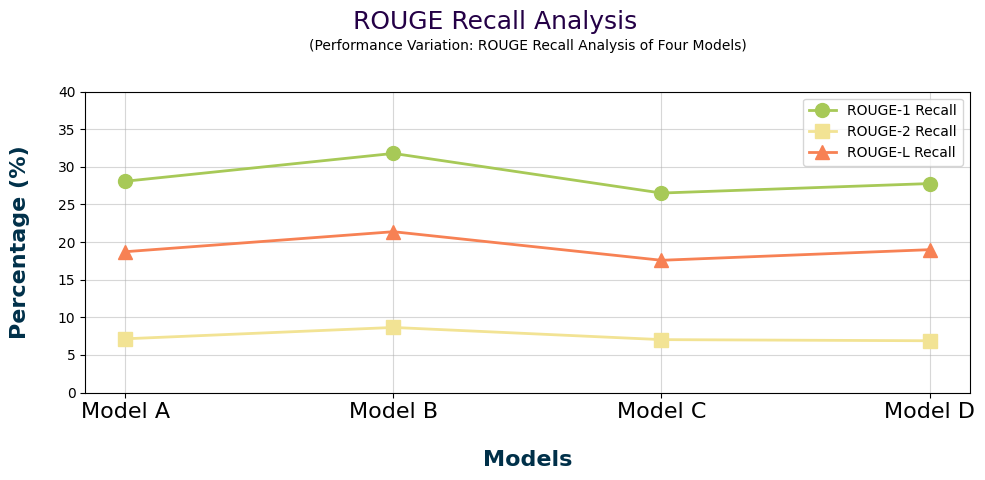

In [ ]:
import matplotlib.pyplot as plt

# Define the size of the plot
plt.figure(figsize=(10, 5))

# Define the models and their performance metrics
models = ['Model A', 'Model B', 'Model C', 'Model D']  # Define the names of the models
rouge1_recall = [28.09, 31.79, 26.52, 27.78]  # Define the ROUGE-1 recall scores for each model
rouge2_recall = [7.14, 8.65, 7.03, 6.88]  # Define the ROUGE-2 recall scores for each model
rougeL_recall = [18.72, 21.38, 17.58, 18.99]  # Define the ROUGE-L recall scores for each model

# Plotting the ROUGE-1 recall scores for each model
plt.plot(models, rouge1_recall, marker='o', label='ROUGE-1 Recall', linestyle='-', color='#a7c957', linewidth=2, markersize=10)

# Plotting the ROUGE-2 recall scores for each model
plt.plot(models, rouge2_recall, marker='s', label='ROUGE-2 Recall', linestyle='-', color='#f2e394', linewidth=2, markersize=10)

# Plotting the ROUGE-L recall scores for each model
plt.plot(models, rougeL_recall, marker='^', label='ROUGE-L Recall', linestyle='-', color='#f78154', linewidth=2, markersize=10)

# Define the title and subtitle of the plot
title = """(Performance Variation: ROUGE Recall Analysis of Four Models)"""
plt.suptitle('ROUGE Recall Analysis', fontsize=18, color='#240046', y=0.95)
plt.title(title, fontsize=10, color='black', pad=30)

# Define the labels for the x-axis and y-axis
plt.xlabel('Models', fontsize=16, fontweight='bold', color='#003049', labelpad=20)
plt.ylabel('Percentage (%)', fontsize=16, fontweight='bold', color='#003049', labelpad=20)

# Display legend and grid lines
plt.legend()
plt.grid(True, alpha=0.5)

# Define the range and ticks for the y-axis
plt.yticks(range(0, 41, 5))

# Rotate the x-axis labels and adjust their fontsize
plt.xticks(rotation=0, fontsize=16)

# Adjust the layout of the plot
plt.tight_layout()

# Show the plot
plt.show()
